# Simulations

This model simulates the calibrated model in response to aggregate-demand shocks and aggregate-supply shocks.

The simulations are based on Section 5 in Michaillat and Saez ([2019](https://www.pascalmichaillat.org/6.html))

In [1]:
# %load setup.py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Calibration

We want to use the following parameters in our simulations:
1. $\epsilon$ : elasticity of substitution between public and private consumption
1. $\eta$ : matching elasticity
1. $s$ : job-separation rate
1. $\omega$ : matching efficiency
1. $\bar{u}$ : average unemployment rate
1. $\bar{x}$ : average labor market tightness
1. $\bar{M}$ : average output multiplier (same as unemployment multiplier)
1. $\bar{G/C}$ : average ratio between public and private employment
1. $\rho$ : the cost of posting a vacancy
1. $\bar{Y}$ : average output
1. $\gamma$ : preference parameter
1. $k$ : productive capacity, which can also be endogenized by adding a labor market where firms hire workers

Under the `Calibration` section of `optimal-stimulus.ipynb`, we already calibrated parameters $1-9$. We can run `optimal-stimulus.ipynb`  to get all calibrated values based on US data between 2001-01-01 and 2019-12-31:

In [2]:
%%capture
%run optimal-stimulus.ipynb

Alternatively, one can uncomment the following code block and set the parameters manually. 

In [3]:
# epsilon = 1 
# eta = 0.6
# s = 0.028 
# omega = 0.60 
# u_bar = 0.061
# x_bar = 0.43
# M_bar = 0.5 
# GC_bar = 0.197 
# rho = 1.08

We now calibrate the remaining parameters as follow:

In [4]:
k = 1 # normalization
Y_bar = k*(1 - u_bar)
gamma = 1/(1 + 1/GC_bar) 

For convenience, we define the functions to calculate key macroeconomic variables  $G/Y, C/Y$, and $G/C$. The expressions for them simply follow from accounting identity.    

In [5]:
GY = lambda gc:gc/(1 + gc) # G/Y
CY = lambda gc:1 - GY(gc)  # C/Y
GC = lambda GY:GY/(1 - GY) # G/C

We then use these functions to calculate target macroeconomic variables.

In [6]:
GY_bar = GY(GC_bar)
CY_bar = CY(GC_bar)
G_bar = GY_bar*Y_bar
C_bar = CY_bar*Y_bar

We can also calculate the price rigidity $r$. At the efficient level, we have that

                $M = \frac{r}{\gamma r + (1-\gamma)\epsilon},$              [![Generic badge](https://img.shields.io/badge/MS19-Eq%20A4-purple?logo=read-the-docs)](https://www.pascalmichaillat.org/6.html)  

which implies that:

                $r = \frac{(1-\gamma)\epsilon M}{1 - \gamma M} = \frac{\overline{C/Y}\epsilon M}{1 - \overline{G/Y} M}.$

In [7]:
r = (M_bar*epsilon*CY_bar)/(1 - M_bar*GY_bar)

We also set up functions for the following labor market parameters. 

The buying rate $q$, as a function of labor market tightness $x$, is:

                $q(x(t)) = \frac{h(t)}{v(t)}=\omega x(t)^{-\eta}.$        [![Generic badge](https://img.shields.io/badge/MS19-p.%201305-purple?logo=read-the-docs)](https://www.pascalmichaillat.org/6.html)  
                
The selling rate $f$, as a function of labor market tightness $x$, is:

                $f(x) = \omega x^{1-\eta}.$             [![Generic badge](https://img.shields.io/badge/MS19-p.%201305-purple?logo=read-the-docs)](https://www.pascalmichaillat.org/6.html) 
                
The matching wedge $\tau$ is:

                $\tau(x) = \frac{\rho s}{q(x) - \rho s}, $             [![Generic badge](https://img.shields.io/badge/MS19-Eq%203-purple?logo=read-the-docs)](https://www.pascalmichaillat.org/6.html) 

In [8]:
q = lambda x:omega*x**(-eta) #buying rate
f = lambda x:omega*x**(1 - eta) #selling rate
tau = lambda x:s*rho/(q(x) - s*rho) #matching wedge

We can also calculate the elasticity of output to tightness. 

First, we have that unemployment rate is: 

                $u(x) = \frac{s}{s+f(x)}.$              [![Generic badge](https://img.shields.io/badge/MS19-Eq%202-purple?logo=read-the-docs)](https://www.pascalmichaillat.org/6.html)  
                

Also, output is given by:

                $Y(x, k) = \frac{f(x)}{s+f(x)}k = (1-u(x))\cdot k.$    [![Generic badge](https://img.shields.io/badge/MS19-Eq%201-purple?logo=read-the-docs)](https://www.pascalmichaillat.org/6.html) 

Thus, the elasticity of output to tightness is:

                $\frac{d\ln{y}}{d\ln{x}} = (1-\eta) * u(x) - \eta * \tau(x).$

In [9]:
u = lambda x:s/(s + f(x))  # unemployment rate
Y = lambda x:(1 - u(x))*k  # output
dlnydlnx = lambda x:(1-eta)*u(x) - eta*tau(x) #elasticity of output to tightness

## Utility Function   [![Generic badge](https://img.shields.io/badge/MS19-p.%20A1~A2-purple?logo=read-the-docs)](https://www.pascalmichaillat.org/6.html)

Given the elasticity of substitution between private and public consumption $\epsilon$, we have the following CES utility function:


                $\mathcal{U}(c, g) = \left((1-\gamma)^{1/\epsilon}c^{(\epsilon-1)/\epsilon} + \gamma ^{1/\epsilon}g^{(\epsilon - 1)/\epsilon}\right)^{\epsilon/(\epsilon - 1)}.$            [![Generic badge](https://img.shields.io/badge/MS19-Eq%208-purple?logo=read-the-docs)](https://www.pascalmichaillat.org/6.html)  

When $\epsilon = 1$, the utility function is Cobb-Douglas:

                $\mathcal{U}(c,g) = \frac{c^{1-\gamma} g^{\gamma}}{(1-\gamma)^{1-\gamma}\gamma^\gamma}.$


In [10]:
if epsilon == 1:
    scalar = (1 - gamma)**(1 - gamma)*gamma**gamma
    U = lambda c, g:c**(1 - gamma)*g**(gamma)/scalar
else:
    U = lambda c, g:((1 - gamma)**(1/epsilon)*c**((epsilon - 1)/epsilon) + 
                     gamma**(1/epsilon)*g**((epsilon - 1)/epsilon))**(epsilon/(epsilon - 1))

With the given utility function, we have the following first derivatives:

                $\frac{\delta \ln{\mathcal{U}}}{\delta \ln{c}} = (1-\gamma)^{{1/\epsilon}} \left(\frac{c}{\mathcal{U}}\right)^{\frac{\epsilon-1}{\epsilon}},\quad \mathcal{U}_c \equiv \frac{\delta \mathcal{U}}{\delta c} = \left((1-\gamma) \frac{\mathcal{U}}{c}\right)^{1/\epsilon},$

                $\frac{\delta \ln{\mathcal{U}}}{\delta \ln{g}} = \gamma^{{1/\epsilon}} \left(\frac{g}{\mathcal{U}}\right)^{\frac{\epsilon-1}{\epsilon}},\quad \mathcal{U}_g \equiv \frac{\delta \mathcal{U}}{\delta g} = \left(\gamma \frac{\mathcal{U}}{g}\right)^{1/\epsilon}.$           [![Generic badge](https://img.shields.io/badge/MS19-p.%20A1-purple?logo=read-the-docs)](https://www.pascalmichaillat.org/6.html)

which gives the marginal rate of substitution:

                $MRS_{gc} = \frac{\mathcal{U}_g}{\mathcal{U}_c}  = \frac{\gamma^{1/\epsilon}}{(1-\gamma)^{1/\epsilon}}*(gc)^{1/\epsilon}.$

We also have the following second derivatives:

                $\frac{\delta \ln{\mathcal{U}_c}}{\delta \ln{c}} = \frac{1}{\epsilon}\left(\frac{\delta \mathcal{U}}{\delta c} -1 \right),$                      

                $\frac{\delta \ln{\mathcal{U}_c}}{\delta \ln{g}} = \frac{1}{\epsilon}\left(\frac{\delta \mathcal{U}}{\delta g} \right).$                        [![Generic badge](https://img.shields.io/badge/MS19-p.%20A2-purple?logo=read-the-docs)](https://www.pascalmichaillat.org/6.html)
                
These derivatives are useful for calculating unemployment multipliers.

In [11]:
dUdc = lambda gc:((1-gamma)*U(1,gc))**(1/epsilon)
dUdc_bar = dUdc(GC_bar)
dUdg = lambda gc:(gamma*U(1/gc, 1))**(1/epsilon)
MRS = lambda gc:gamma**(1/epsilon)/(1-gamma)**(1/epsilon)*gc**(1/epsilon)
dlnUdlnc = lambda gc:(1 - gamma)**(1/epsilon)*(U(1, gc))**((1 - epsilon)/epsilon)
dlnUdlng = lambda gc:gamma**(1/epsilon)*(U(1/gc, 1))**((1 - epsilon)/epsilon)
dlnUcdlnc = lambda gc:(dlnUdlnc(gc) - 1)/epsilon
dlnUcdlng = lambda gc:dlnUdlng(gc)/epsilon

## Unemployment Multipliers   [![Generic badge](https://img.shields.io/badge/MS19-p.%20A2~A3-purple?logo=read-the-docs)](https://www.pascalmichaillat.org/6.html)

We now move on to compute the theoretical unemployment multiplier and the output multiplier.

First, we want to compute the effect of public consumption on the price of services, which requires us to look at the price mechanism. It is rigid since it does not respond to demand shocks, and is an expression of the multiplier:

                $p(G) = p_0 \left\{ (1-\gamma) + \gamma ^{\frac{1}{\epsilon}}\left[(1-\gamma)\frac{g}{y^*-g}\right]^{\frac{\epsilon-1}{\epsilon}}\right \}^\frac{1-r}{\epsilon - 1}.$                    [![Generic badge](https://img.shields.io/badge/MS19-Eq%2015-purple?logo=read-the-docs)](https://www.pascalmichaillat.org/6.html)

which gives us:

                $\frac{d\ln{p}}{d\ln{g}} = (1-r) \left[ \frac{\delta\ln{\mathcal{U}_c}}{\delta \ln{g}} - \frac{G}{y^* - G} \frac{\delta\ln{\mathcal{U}_c}}{\delta \ln{c}}  \right].$                        [![Generic badge](https://img.shields.io/badge/MS19-Eq%20A4-purple?logo=read-the-docs)](https://www.pascalmichaillat.org/6.html)

In [12]:
# initial price level
p0 = dUdc_bar**r/(1 + tau_bar) 
p = lambda G:p0*dUdc(G/(Y_bar-G))**(1 - r)
dlnpdlng = lambda G:(1 - r)*(dlnUcdlng(G/(Y_bar - G)) - dlnUcdlnc(G/(Y_bar - G))*(G/(Y_bar - G)))

Then we want to compute the effects of public consumption and tightness on private demand, which are:

                $\frac{\delta\ln{c}}{\delta \ln{x}} = \frac{\eta \tau(x)}{\delta \ln{\mathcal{U}_c}/\delta\ln(c)},$                        [![Generic badge](https://img.shields.io/badge/MS19-Eq%20A6-purple?logo=read-the-docs)](https://www.pascalmichaillat.org/6.html)

and

                $\frac{\delta\ln{c}}{\delta \ln{g}} = \frac{d \ln{p}/d\ln(g) - \delta \ln{\mathcal{U}_c}/\delta\ln(g)}{\delta \ln{\mathcal{U}_c}/\delta\ln(c)}.$                   [![Generic badge](https://img.shields.io/badge/MS19-Eq%20A7-purple?logo=read-the-docs)](https://www.pascalmichaillat.org/6.html)



In [13]:
dlncdlnx = lambda G, x:eta*tau(x)/dlnUcdlnc(G/(Y(x)-G))
dlncdlng = lambda G, x:(dlnpdlng(G)-dlnUcdlng(G/(Y(x)-G)))/dlnUcdlnc(G/(Y(x)-G))

We can also determine the effect of public consumption on equilibrium tightness, which is:

                $\frac{\delta\ln{x}}{\delta \ln{g}} = \frac{(g/y) + (c/y)\delta\ln{c}/\delta\ln{g}}{\delta\ln{y}/\delta\ln{x} - (c/y)\delta\ln{c}/\delta\ln{x}}.$                   [![Generic badge](https://img.shields.io/badge/MS19-Eq%20A9-purple?logo=read-the-docs)](https://www.pascalmichaillat.org/6.html)

In [14]:
dlnxdlng = lambda G, x:(G/Y(x) + (1 - G/Y(x))*dlncdlng(G, x))/(dlnydlnx(x) - (1-G/Y(x))*dlncdlnx(G, x))

Thus, we can compute the theoretical unemployment multiplier

                $m = (1-\eta) (1-u) u \frac{y}{g}\frac{d\ln{x}}{d\ln{g}},$

and the empirical unemployment multiplier

                $M = \frac{m}{1- u + \frac{g}{y}\frac{\eta}{1-\eta}\frac{\tau}{u}m}.$                         [![Generic badge](https://img.shields.io/badge/MS19-Eq%20A11-purple?logo=read-the-docs)](https://www.pascalmichaillat.org/6.html)


In [15]:
m = lambda G, x:(1 - eta)*u(x)*(1 - u(x))*dlnxdlng(G, x)*Y(x)/G 
M = lambda G, x:m(G, x)/(1 - u(x) + G/Y(x)*eta*tau(x)/(1 - eta)/u(x)*m(G, x))

### Simulations

We will now run simulations under different shocks. To determine equilibrium under different aggregate demand/government spending, we need to find where aggreagte demand is equal to aggregate supply, which happens when 

                $\frac{dU}{dc} - G = (1+\tau)\frac{p(G)}{\alpha}$                       [![Generic badge](https://img.shields.io/badge/MS19-Eq%2013-purple?logo=read-the-docs)](https://www.pascalmichaillat.org/6.html)

In [27]:
findeq = lambda G, x, alpha:abs(dUdc(G/(Y(x) - G)) - ((1 + tau(x))*p(G)/alpha))

We will now run business cycle simulations under aggregate demand shocks, fixing the public expenditure policy at $G/Y = 16.5\%$. For each magnitude of aggregate demand, we find the equilibrium labor market tightness using grid search. 

In [17]:
# Range of aggregate demand
ALPHA = np.arange(start=0.97, step=0.0025, stop=1.03) 
# Grid to search for equilibrium tightness x
x0 = np.arange(start=0.001, step=0.0002, stop=2) 
xad, Gad = np.empty(len(ALPHA)), np.empty(len(ALPHA))
G0 = GY_bar*Y(x0)	# G such that G/Y=16.5%
for i, alpha in enumerate(ALPHA):
    eva = findeq(G0, x0, alpha)
    # Finding where AS = AD
    ind = np.argmin(eva)
    # Record equlibrium tightness and public expenditure
    xad[i] = x0[ind]
    Gad[i] = G0[ind]

We then compute all other equilibrium variables with $G/Y = 16.5\%$ under the aggregate demand shocks. 

In [18]:
Yad = Y(xad) # output
GYad = Gad/Yad # G/Y
uad = u(xad) # unemployment rate
Mad = M(Gad, xad) # output multiplier

We then run business-cycle simulations under public spending shocks. We compute equilibrium variables for a range of public spending to output ratios $G/Y$.

In [19]:
# Range of public expenditure G/Y
GY0 = np.arange(start=0.1, step=0.00005, stop=0.25) 
xgy, Ggy = np.empty(len(GY0)), np.empty(len(GY0))
for i, gy in enumerate(GY0):
    # Find G such that G/Y=gy
    G0 = gy*Y(x0)
    eva = findeq(G0, x0, 1)
    ind = np.argmin(eva)
    # Record equlibrium tightness and public expenditure
    xgy[i]=x0[ind]
    Ggy[i]=G0[ind]

And we compute all other macro variables of interest:

In [20]:
Ygy = Y(xgy)      # output
GYgy = Ggy/Ygy    # G/Y
ugy = u(xgy)      # unemployment rate
Mgy = M(Ggy, xgy) # output multiplier

Let's first look at equilibria under aggregate demand shocks:

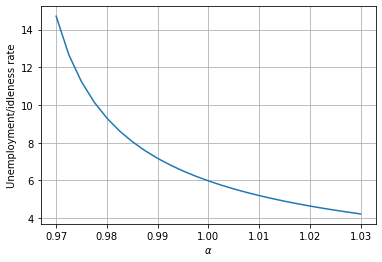

In [21]:
# Unemployment
fig, ax = plt.subplots()
ax.plot(ALPHA, uad*100)
ax.set(xlabel=r'$\alpha$', ylabel='Unemployment/idleness rate')
ax.grid()
plt.show()

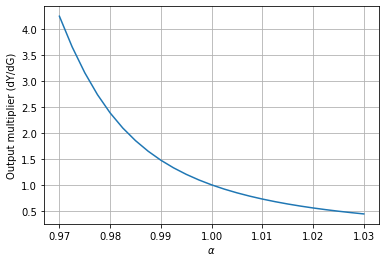

In [22]:
# Output multiplier
fig, ax = plt.subplots()
ax.plot(ALPHA, Mad)
ax.set(xlabel=r'$\alpha$', ylabel='Output multiplier (dY/dG)')
ax.grid()
plt.show()

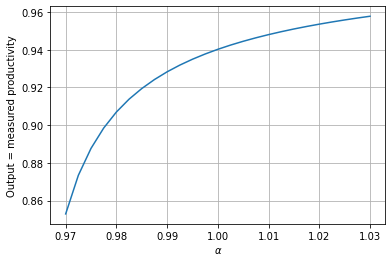

In [23]:
# Output 
fig, ax = plt.subplots()
ax.plot(ALPHA, Yad)
ax.set(xlabel=r'$\alpha$', ylabel='Output = measured productivity')
ax.grid()
plt.show()

We will then examine equilibria under different government spending:

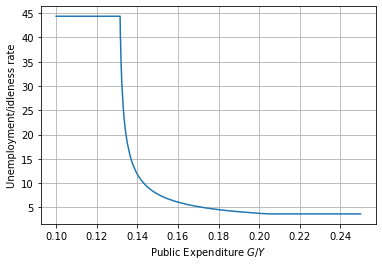

In [24]:
# Unemployment Rate
fig, ax = plt.subplots()
ax.plot(GY0, ugy*100)
ax.set(xlabel=r'Public Expenditure $G/Y$', ylabel='Unemployment/idleness rate')
ax.grid()
plt.show()

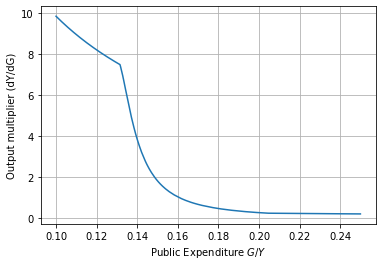

In [25]:
# Output Multiplier
fig, ax = plt.subplots()
ax.plot(GY0, Mgy)
ax.set(xlabel=r'Public Expenditure $G/Y$', ylabel='Output multiplier (dY/dG)')
ax.grid()
plt.show()

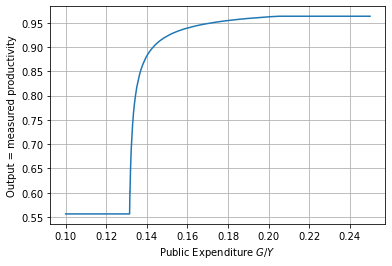

In [26]:
# Output
fig, ax = plt.subplots()
ax.plot(GY0, Ygy)
ax.set(xlabel=r'Public Expenditure $G/Y$', ylabel='Output = measured productivity')
ax.grid()
plt.show()